# Creating Project

In [4]:
import warnings
warnings.filterwarnings("ignore")

from datetime import datetime
import mitzu.model as M


p = M.Project(
        event_data_tables=[
            M.EventDataTable.create(
                table_name="sub_events",
                event_name_alias="user_subscribe",
                event_time_field="subscription_time",
                user_id_field="subscriber_id",
            ),
            M.EventDataTable.create(
                table_name="web_events",
                event_name_field="event_name",
                event_time_field="event_time",
                date_partition_field="event_time",
                user_id_field="user_id",
                event_specific_fields=["event_properties"],
            ),
        ],
        default_end_dt=datetime(2021, 4, 1),
        default_discovery_lookback_days=10,
        default_property_sample_size=1000,
        connection=M.Connection(
            connection_type=M.ConnectionType.TRINO,
            user_name="test",
            secret_resolver=None,
            schema="tiny",
            catalog="minio",
            host="localhost",
        ),
    )

# Saving Project to File

In [5]:
dp = p.discover_project()
res = dp.save_to_project_file("trino_test_project")

Discovering sub_events
Discovering generic field enums
Discovering event specific field enums
Discovering web_events
Discovering generic field enums
Discovering event specific field enums


# Loading Project

In [8]:
dp = M.DiscoveredProject.load_from_project_file("trino_test_project")
m = dp.create_notebook_class_model()

# Product Analytics From Loaded Project

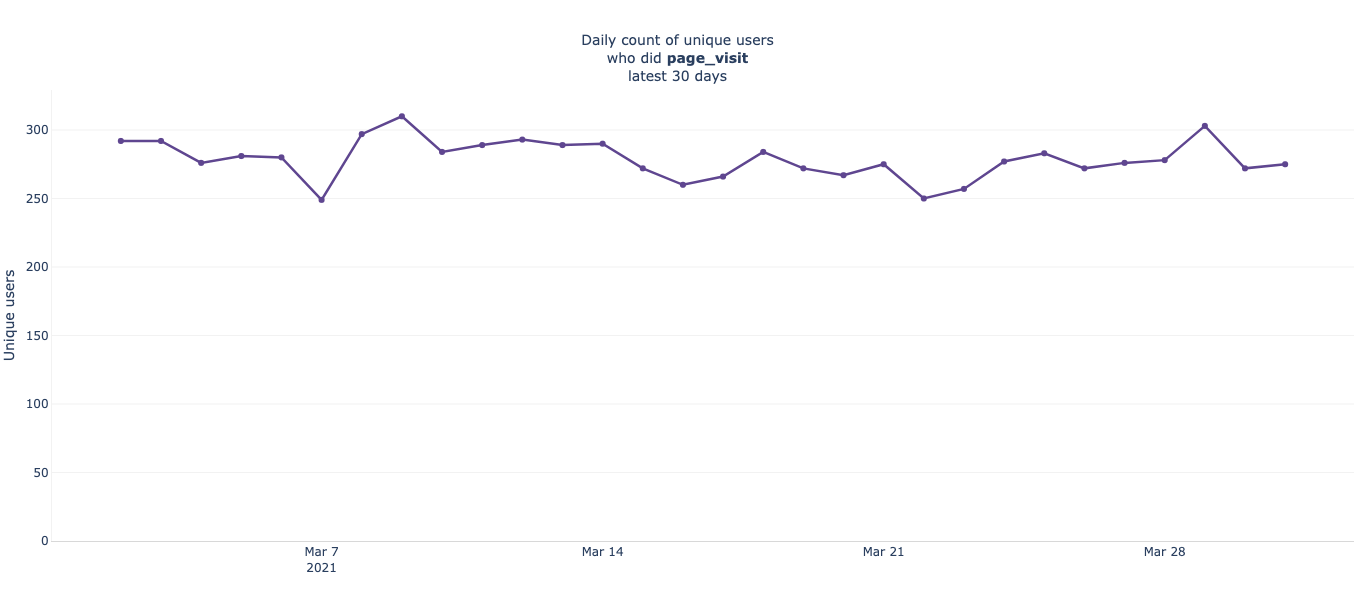

In [10]:
m.page_visit

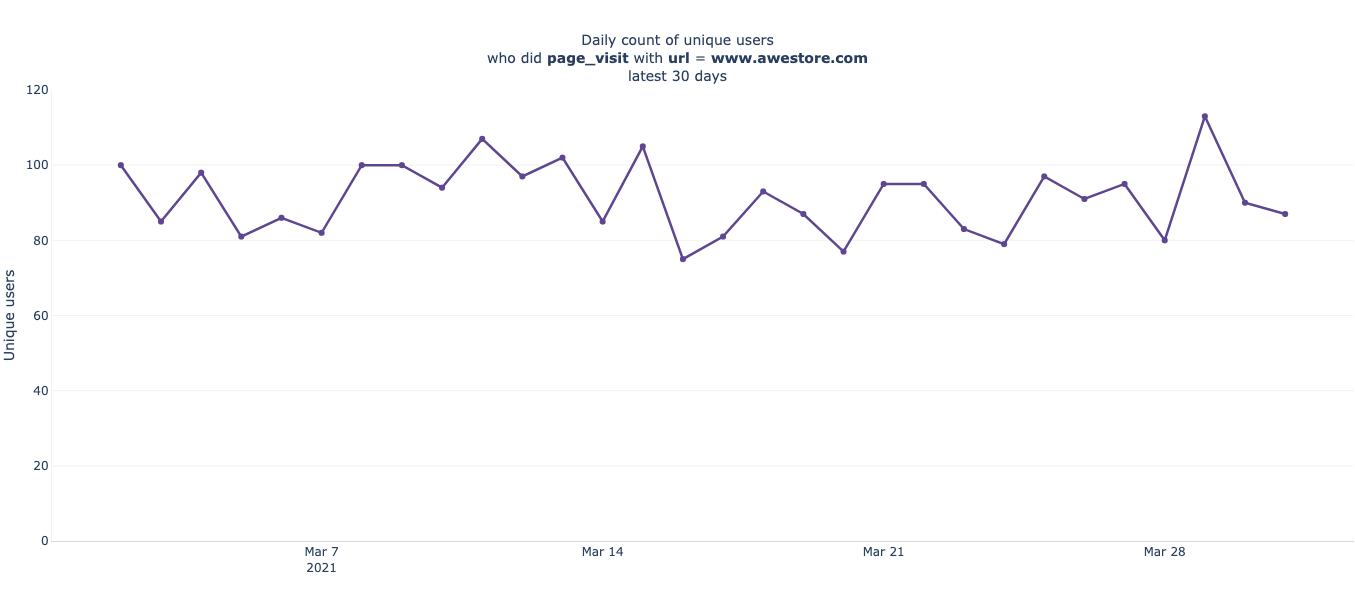

In [21]:
m.page_visit.event_properties.url.is_www_awestore_com

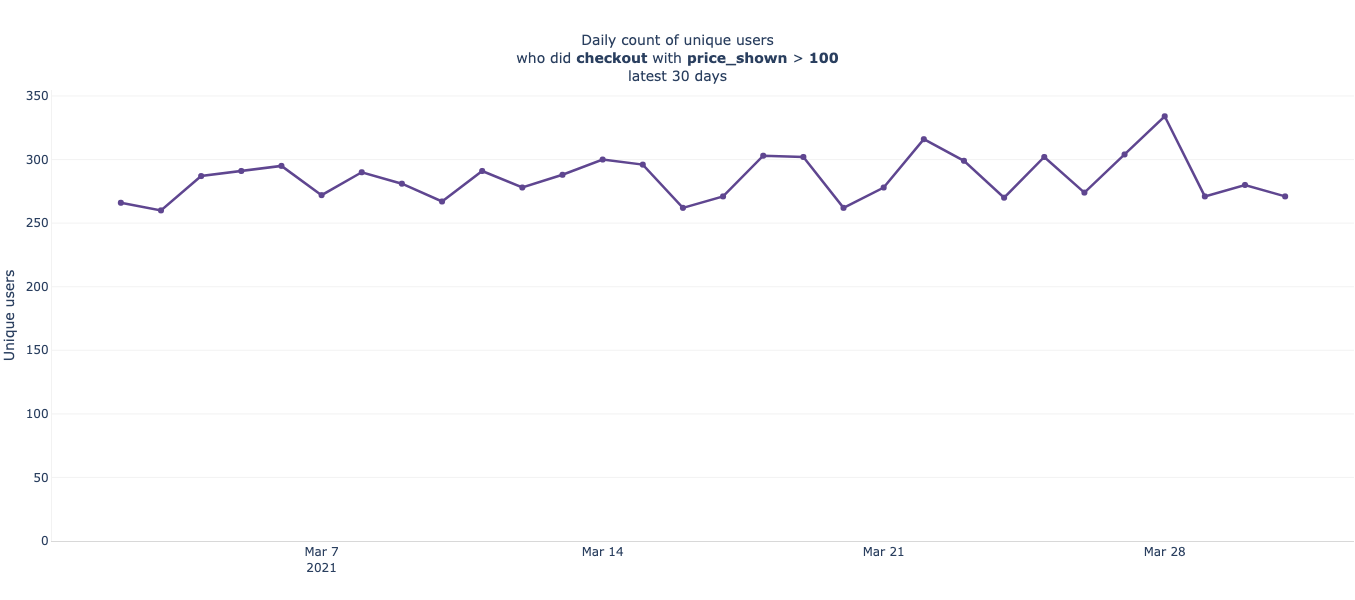

In [12]:
m.checkout.event_properties.price_shown > 100

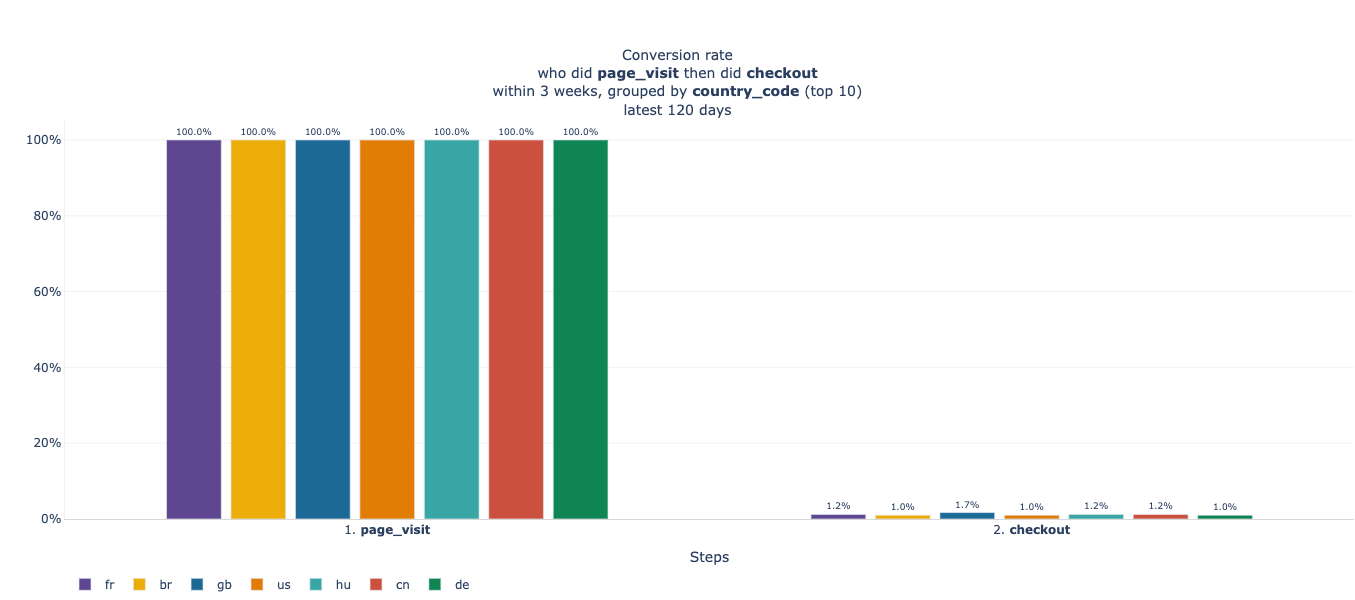

In [18]:
(m.page_visit >> m.checkout).config(time_group="total", 
                                    conv_window="3 week", 
                                    group_by=m.page_visit.user_properties.country_code, 
                                    lookback_days=120)

In [22]:
(m.page_visit >> m.checkout).config(time_group="total", 
                                    conv_window="3 week", 
                                    group_by=m.page_visit.user_properties.country_code, 
                                    lookback_days=120).print_sql()

WITH anon_1 AS
  (SELECT tiny.web_events.user_id AS _cte_user_id,
          tiny.web_events.event_time AS _cte_datetime,
          web_events.user_properties.country_code AS _cte_group
   FROM tiny.web_events
   WHERE tiny.web_events.event_name = 'page_visit'
     AND date(tiny.web_events.event_time) >= date('2020-12-02')
     AND date(tiny.web_events.event_time) <= date('2021-04-22')),
     anon_2 AS
  (SELECT tiny.web_events.user_id AS _cte_user_id,
          tiny.web_events.event_time AS _cte_datetime,
          NULL AS _cte_group
   FROM tiny.web_events
   WHERE tiny.web_events.event_name = 'checkout'
     AND date(tiny.web_events.event_time) >= date('2020-12-02')
     AND date(tiny.web_events.event_time) <= date('2021-04-22'))
SELECT NULL AS _datetime,
       anon_1._cte_group AS _group,
       count(DISTINCT anon_1._cte_user_id) AS _user_count_1,
       (count(DISTINCT anon_1._cte_user_id) * 100.0) / count(DISTINCT anon_1._cte_user_id) AS _agg_value_1,
       count(DISTINCT anon_